In [1]:
#Lennard-Jones chain simulation, v 1.0 on cpu

In [2]:
# import hoomd packages and molecular dynamics component

from __future__ import division
import hoomd
import hoomd.md


#--- Initialization
# define parameters for this simulation

gb_kappa = 5.0;
gb_parallel_semiaxis = gb_kappa/2.0;
gb_perpendicular_semiaxis = 0.50;
gb_epsilon =1.0;
gb_r_cut = 6.5;

density= 0.005;
temperature= 0.70; 
md_time_step = 0.001

print("rho= ", density)
print("T= ", temperature);
print("dt= ", md_time_step);

unit_cell_side_3 = 1.0/(gb_kappa*density)**(1./3.);
unit_cell_side_2 = unit_cell_side_3
unit_cell_side_1 = gb_kappa*unit_cell_side_3;

n_x = 4;
n_y = 15;
n_z = n_y;

n_xyz = n_x * n_y * n_z;

print("cell sides= ", unit_cell_side_1, unit_cell_side_2, unit_cell_side_3);
print("repeats= "   , n_x, n_y, n_z);
print("particles="  , n_xyz);

log_file= "log_rho_" + str(density) + "_T_" + str(temperature) + ".log";
log_period = 1e3;

trajectory_file= "trajectory_rho_" + str(density) + "_T_" + str(temperature) + ".gsd";
trajectory_period = 1e3;

print("output files:", trajectory_file, ",", log_file)

# ----- Begin hoomd code ----


# ----- System initialization
# initialize execution context (automatic selection between GPU and CPU)
hoomd.context.initialize("")

# create a single particle snapshot that will house a unit cell
# snap = hoomd.data.make_snapshot(N=1, 
#                                box=hoomd.data.boxdim(L=box_side), 
#                                particle_types=['A'])

# initialize a unit cell with a single particle, then replicate it as needed
uc = hoomd.lattice.unitcell(N = 1,
                            a1 = [unit_cell_side_1, 0,   0],
                            a2 = [0,    unit_cell_side_2, 0],
                            a3 = [0,    0,   unit_cell_side_3],
                            dimensions = 3,
                            position = [[0,0,0]],
                            type_name = ['R'],
                            mass = [1.0],
                            moment_inertia = [[0,
                                               1/12*1.0*8**2,
                                               1/12*1.0*8**2]],
                            orientation = [[1, 0, 0, 0]]);

# Create lattice from previous unit cell
system = hoomd.init.create_lattice(unitcell=uc, n=[n_x,n_y,n_z]);

volume = n_x*unit_cell_side_1*n_y*unit_cell_side_2*n_y*unit_cell_side_3 
mass_test = n_x*n_y*n_z
density = mass_test/volume
print("The density is" ,density)
#snapshot = system.take_snapshot(all=True)
#print(snapshot.box)

rho=  0.005
T=  0.7
dt=  0.001
cell sides=  17.09975946676697 3.4199518933533937 3.4199518933533937
repeats=  4 15 15
particles= 900
output files: trajectory_rho_0.005_T_0.7.gsd , log_rho_0.005_T_0.7.log
HOOMD-blue v2.3.1-1-gb7f98d0 CUDA (8.0) DOUBLE HPMC_MIXED MPI SSE SSE2 SSE3 
Compiled: 06/07/18
Copyright 2009-2018 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, C D Lorenz, and A Travesset. "General purpose molecular dynamics
  simulations fully implemented on graphics processing units", Journal of
  Computational Physics 227 (2008) 5342--5359
* J Glaser, T D Nguyen, J A Anderson, P Liu, F Spiga, J A Millan, D C Morse, and
  S C Glotzer. "Strong scaling of general-purpose molecular dynamics simulations
  on GPUs", Computer Physics Communications 192 (2015) 97--107
-----
notice(2): NVIDIA driver not installed or is too old, ignoring any GPUs in the system.
HOOMD-blue is running on the CPU
notice(2): Group "all" cre

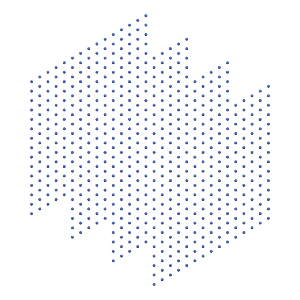

In [3]:
import ex_render
ex_render.render_sphere_frame(system.take_snapshot())

In [4]:
system.particles.types.add('A');
rigid = hoomd.md.constrain.rigid();
rigid.set_param('R', 
                types=['A']*8,
                positions=[(-4,0,0),(-3,0,0),(-2,0,0),(-1,0,0),
                           (1,0,0),(2,0,0),(3,0,0),(4,0,0)]);

rigid.create_bodies()

notice(2): constrain.rigid(): Creating 900 rigid bodies (adding 7200 particles)


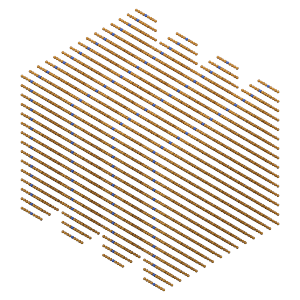

In [5]:
ex_render.render_sphere_frame(system.take_snapshot())

In [6]:
#--- Define interactions

# Choose the cell-list structure to create the neighbor lists
nl = hoomd.md.nlist.cell()

lj = hoomd.md.pair.lj(r_cut=2**(1/6), nlist=nl)
lj.set_params(mode='shift')

lj.pair_coeff.set(['R', 'A'], ['R', 'A'], epsilon=1.0, sigma=1.0)

#--- Select integrator

# Choose mode standard with a time step of 0.005
hoomd.md.integrate.mode_standard(dt=md_time_step)

rigid = hoomd.group.rigid_center();
#hoomd.md.integrate.langevin(group=rigid, kT=1.0, seed=42);

integrator = hoomd.md.integrate.nvt(group=rigid, kT=temperature,  tau=1.0)
integrator.randomize_velocities(seed=42)

notice(2): Group "rigid_center" created containing 900 particles


In [7]:
#--- Select quantities and period to be logged

# The .log file is a text table
log1 = hoomd.analyze.log(filename=log_file,
                         quantities=['translational_kinetic_energy', 
                                   'rotational_kinetic_energy', 
                                   'potential_energy', 
                                   'temperature', 
                                   'pressure'],
                         period=log_period,
                         overwrite=True);

# The.gsd file is a binary trajectory in GSD format
hoomd.dump.gsd(trajectory_file, 
               period= trajectory_period, 
               group=hoomd.group.all(), 
               overwrite=True)

#hoomd.option.set_notice_level(0) # verbosity level: 0 is minimum, 10 is maximum

In [8]:
hoomd.run(10e4)

notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 8100
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: yes
** starting run **
Time 00:00:20 | Step 4354 / 100000 | TPS 435.373 | ETA 00:03:39
Time 00:00:30 | Step 9086 / 100000 | TPS 473.142 | ETA 00:03:12
Time 00:00:40 | Step 13770 / 100000 | TPS 468.376 | ETA 00:03:04
Time 00:00:50 | Step 18246 / 100000 | TPS 447.494 | ETA 00:03:02
Time 00:01:00 | Step 22313 / 100000 | TPS 406.648 | ETA 00:03:11
Time 00:01:10 | Step 27116 / 100000 | TPS 480.276 | ETA 00:02:31
Time 00:01:20 | Step 31618 / 100000 | TPS 450.153 | ETA 00:02:31
Time 00:01:30 | Step 35682 / 100000 | TPS 406.341 | ETA 00:02:38
Time 00:01:40 | Step 40334 / 100000 | TPS 465.028 | ETA 00:02:08
Time 00:01:50 | Step 45123 / 100000 | TPS 478.893 | ETA 00:01:54
Time 00:02:00 | Step 49988 / 100000 | TPS 486.439 | ETA 00:01:42
Time 00:02:10 | Step 54641 / 100000 | TPS 46